## Title TBD

The Mexican blind cave fish (Astyanax mexicanus) is a freshwater fish living in large sections of the southwest, including New Mexico, Texas and eastern and central Mexico (1). Populations of this fish dwell in dark caves, resulting in de-pigmentation and degenerated or total loss of eyesight. Due to the commonality of the Astyanax and the two separate populations, surface and cave, it has been an ideal model for studying eye development (and lack thereof) (2). Even though the cave population of the fish are blind, they are still able to avoid objects and hunt for prey by using their lateral line. This sensory system allows a fish to respond to changes in its surroundings by detecting flow stimuli, governed by hydrodynamics (3). 


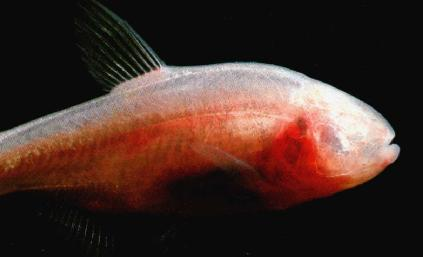

In [1]:
from IPython.display import Image
Image("image_blindCaveFish.jpg")

This project will explore the changes in flow around a blind cave fish as it glides towards a wall by using potential flow theory. Building off work done by Hassan (1991), this project will use a panel method on a NACA 0012 airfoil to represent the body of the fish. After establishing what the flow looks like surrounding the fish in open water, a wall will be added to the flow and the body of the fish will be moved progressively closer to the wall, looking at changes in streamlines and pressure coefficient along the body.  


In [2]:
#First, let's import our libraries 
import numpy
import os
import math
from scipy import integrate
from matplotlib import pyplot 
%matplotlib inline 

In [3]:
#Grid information
Ng = 100 
x_start, x_end = -2.5, 2.5
y_start, y_end = -2.0, 2.0
x = numpy.linspace(x_start, x_end, Ng)
y = numpy.linspace(y_start, y_end, Ng)
X,Y = numpy.meshgrid(x,y)

u_inf = 1.0

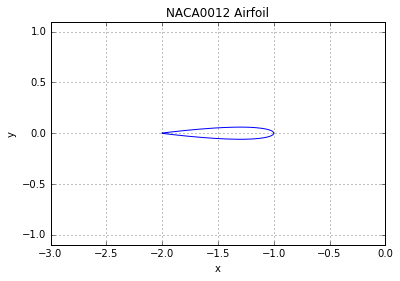

In [23]:
#We will import the NACA 0012 airfoil 

naca_filepath = os.path.join('naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = numpy.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

#x_airfoil = (-1.0*x)-1.0
#y_airfoil = (-1.0*y)

size=4

pyplot.plot(x_airfoil,y_airfoil)
pyplot.ylim(-1.1, 1.1)
pyplot.xlim(-3.0, 0.0)
pyplot.grid(True)

pyplot.title('NACA0012 Airfoil')
pyplot.xlabel('x')
pyplot.ylabel('y')

In [5]:
#We will use our vortex-source panel method to discretize the airfoil into panels

class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient
        
def define_panels(x, y, N=40):
    """ 
    Discretizes the geometry into panels using the cosine
    
    x: x-coordinate of the points defining the geometry 
    y: y-coordinate of the points defining the geometry 
    N: number of panels 
    
    panels: the discretization of the geometry into panels 
    """
    
    R = (x.max()-x.min())/2           #radius of circle
    x_center = (x.max()+x.min())/2            #x coordinate of the center
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))  #x coordinates of the circle points
    
    x_ends = numpy.copy(x_circle)     #projection of the x coord on the surface
    y_ends = numpy.empty_like(x_ends)   #initialization of y coord numpy array
    
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])   #extend arrays using numpy.append
    
    #computes the y-coordinate of end points 
    
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break 
            else:
                I += 1
                
        a = (y[I+1] - y[I]) / (x[I+1] - x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
        
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

(-0.1, 0.1)

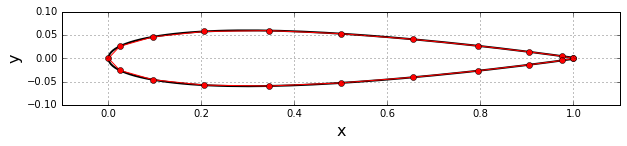

In [6]:
N = 20 
panels = define_panels(x, y, N)

width=10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
           numpy.append([panel.ya for panel in panels], panels[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1)

In [7]:
#What does the fish look like in freestream? We will adapt our code from Lesson 10 to find out!
class Freestream:
    """
    Freestream conditions
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle with the x axis 
        
        u_inf: freestream speed 
        alpha: angle of attack in degrees"""
        
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180

In [8]:
alpha = 0.0 
freestream = Freestream(u_inf, alpha)

In [9]:
def integral(x, y, panel, dxdz, dydz):
 
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [10]:
def build_matrix(panels):
    """Builds the source matrix 
    panels: the source panels
    A: the source matrix, NxN matrix
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
                
    return A 

def build_rhs(panels, freestream):
    """Builds the RHS of the linear system
    panels: the source panels
    freestream: freestream conditions 
    b: RHS of the linear system"""
    
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
        
    return b

In [11]:
A = build_matrix(panels)
b = build_rhs(panels, freestream)

In [12]:
#solve the linear system 
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [13]:
def get_tangential_velocity(panels, freestream):
    """Computes the tangential velocity on the surface of the panel 
    panels: the source panels
    freestream: the freestream conditions 
    """
    N = len(panels)
    A = numpy.empty((N,N), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
                
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt = numpy.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [14]:
#compute the tangential velocity at the center-point of each panel 
get_tangential_velocity(panels, freestream)

In [15]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients on the panels
    panels: source panels
    freestream: freestream conditions
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [16]:
get_pressure_coefficient(panels, freestream)

In [17]:
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths: {}'.format(accuracy))

--> sum of source/sink strengths: 0.00938885414285518


In [18]:
def get_velocity_field(panels, freestream, X, Y):
    """Computes the velocity field on a given 2D mesh 
    panels: the source panels
    freestream: freestream conditions 
    X: x-coordinates of the mesh points
    Y: y-coordinates of the mesh points
    
    u: x-component of the velocity vector field 
    v: y-component of the velocity vector field 
    """
    
    #freestream contribution
    u = (freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float))
    v = (freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float))
    
    #add contribution from each source (superposition) 
    vec_integral = numpy.vectorize(integral)
    for panel in panels:
        u += (panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 1, 0))
        v += (panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 0, 1))
        
    return u, v

In [19]:
uF, vF = get_velocity_field(panels, freestream, X, Y)

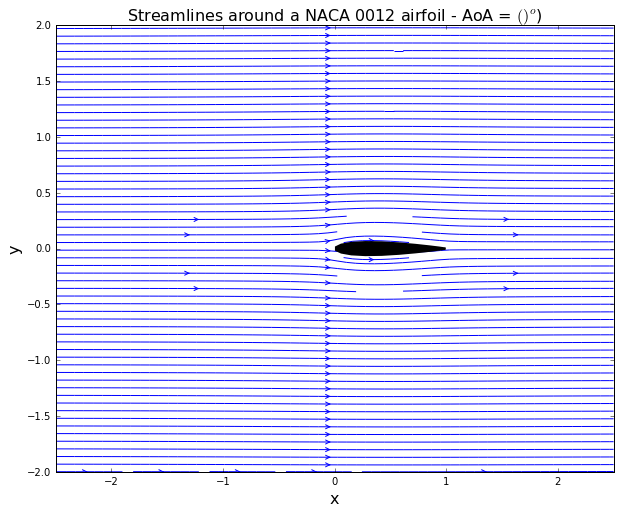

In [20]:
#plot velocity field 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X,Y,uF,vF,
                 density=2.0, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels], 
           [panel.yc for panel in panels],
           color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil - AoA = $()^o$)'.format(alpha), fontsize=16);

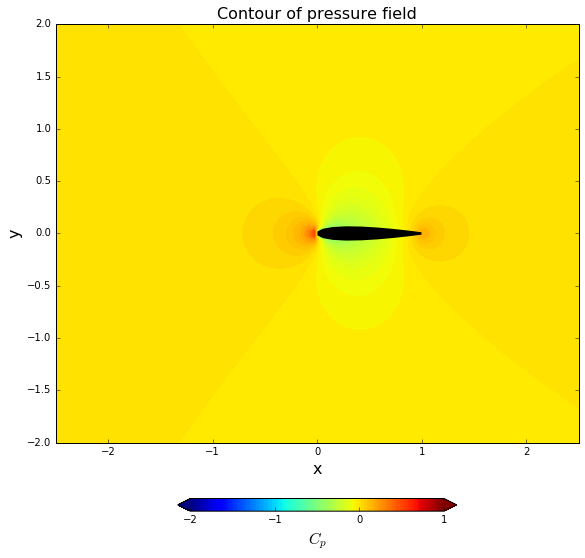

In [21]:
# compute the pressure field
cp = 1.0 - (uF**2+vF**2)/freestream.u_inf**2

# plot the pressure field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);

## Adding the wall

In [24]:
#We will add a wall to our flow perpendicular to the fish

u_freestreamS = u_inf * numpy.ones((Ng,Ng), dtype=float)
v_freestreamS = numpy.zeros((Ng,Ng), dtype=float)

class Source: 
    
    def __init__(self, strength, x, y):
        
        self.strength = strength
        self.x, self.y = x,y
        
    def velocity(self, X, Y):
        
        self.u = self.strength/(2*math.pi)*(X-self.x)/((X-self.x)**2 + (Y-self.y)**2)
        self.v = self.strength/(2*math.pi)*(Y-self.y)/((X-self.x)**2 + (Y-self.y)**2)
        
    def stream_function(self, X, Y):
        
        self.psi = self.strength/(2*math.pi)*numpy.arctan2((Y-self.y), (X-self.x))
        
N_sources = 40
strength = 1.0 
strength_source = strength/N_sources
x_source = numpy.zeros(N_sources, dtype=float)
y_source = numpy.linspace(-1.0, 1.0, N_sources)

sources = numpy.empty(N_sources, dtype=object)
for i in range(N_sources):
    sources[i] = Source(strength_source, x_source[i], y_source[i])
    sources[i].velocity(X, Y)
    
u = u_freestreamS.copy()
v = v_freestreamS.copy()
for source in sources:
    u += source.u
    v += source.v    


sigma = 2*u_inf
y_min, y_max = -1.0, 1.0 

integrand_u = lambda s, x, y: x/(x**2 + (y-s)**2)
integrand_v = lambda s, x, y: (y-s)/(x**2 + (y-s)**2)

def integration(x, y, integrand):
    return integrate.quad(integrand, y_min, y_max, args=(x, y))[0]

vec_integration = numpy.vectorize(integration)

u_sheet = sigma/(2.0*numpy.pi)*vec_integration(X,Y,integrand_u)
v_sheet = sigma/(2.0*numpy.pi)*vec_integration(X,Y,integrand_v)

u_wall = -(u_freestreamS + u_sheet)
v_wall = -(v_freestreamS + v_sheet)

In [28]:
U = u_wall + uF
V = v_wall + vF

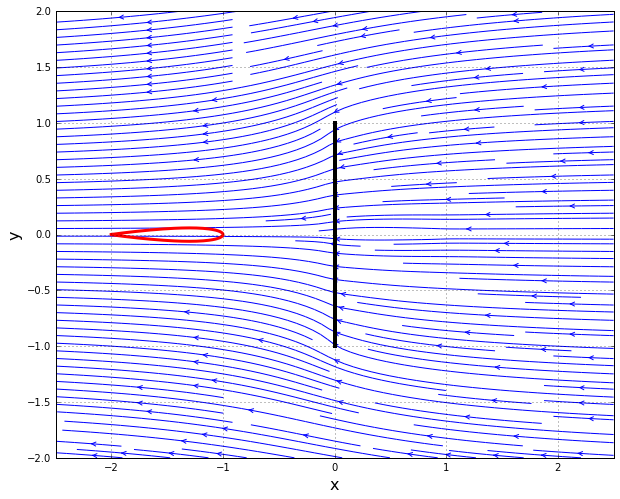

In [29]:
size=10
pyplot.figure(figsize=(size,(y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, U, V, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.axvline(0.0, (y_min-y_start)/(y_end-y_start), (y_max-y_start)/(y_end-y_start), color='k', linewidth=4)

magnitude = numpy.sqrt(u**2 + v**2)
j_stagn, i_stagn = numpy.unravel_index(magnitude.argmin(), magnitude.shape)

pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

pyplot.plot(x_airfoil,y_airfoil, color='r',linewidth=3)


In [ ]:
#We will detect changes in the pressure coefficient as we move the fish closer to the wall

In [ ]:
#Plot changes in coefficient of pressure with respect to gap between fish and wall 

## Now let's look at what happens to a fish swimming parallel to the wall... 

In [ ]:
#We will move the location of our wall from perpendiciular to parallel 

In [ ]:
#Plot

In [ ]:
#We will detect changes in the pressure coefficient as we move the fish closer to the wall

In [ ]:
#Plot changes in coefficient of pressure with respect to gap between fish and wall 

## How do our results compare to the literature? 

Discussion; model limitations

## Challenge question: 

## References

[1]
